# Exercise

### Keras

For this exercise we will use the neural network module <code>keras</code>.

We can create networks in keras using one of two APIs
    1. the Sequential API
    2. the functional API

Using the sequential API can produce neural networks with layers that have one predecessor and one successor. For any other connections between layers one must use the functional API. In this tutorial we will use the Sequential API (keras.models.Sequential) to build an autoencoder and a classifier

Steps to create a neural network in keras:

1. <code>mymodel = Sequential()</code> - create model using Sequential API
2. add layers using <code>mymodel.add(layer)</code>. A selection of layers can be found in keras.layers but in this exercise we will only use the Dense layer class, which adds a fully connected layer to the network.
<code>Dense(100, activation='sigmoid')</code> for example will add a layer of 100 neurons with a sigmoid activation function.
3. After your layers are added, the network needs to be compiled <code>mymodel.compile(loss=loss, optimizer=optimizer)</code>. In this step, the network is transformed into datastructures of lower-level libraries (the backend of keras).
4. Calling <code>fit(x, y, epochs=nb_epochs)</code> will then fit the parameters of the model to the data using the optimizer and the loss calculated by the loss function
5. After the model is fit, you can get new predictions using <code>mymodel.predict(x)</code> and evaluate the performance



- Exercise 1: Autoencoder
    1. Look at the predefined autoencoder class and how it uses keras to setup the network in <code>_init_ae(self, dims, loss, optimizer, activation)</code>. Use the AutoEncoder class to create an Autoencoder network with an encoder that reduces the dimensionality to 2
    2. Train the network on the cancer dataset from yesterdays exercise using mean squared error loss ('mse') and stochastic gradient descent (SGD class under sklearn.optimizer) with a learning rate of 0.05
    3. Visualize the embedded data
- Exercise 2: Classification
    1. Create and train a classifier using a keras-Sequential model and evaluate its classification performance on the breast cancer dataset. Use 80% of the data for training and 20% for testing
    2. Bonus: Study the effect of Dropout on the classification performace

In [1]:
from keras.layers import Input, Dense
from keras.models import Sequential
from matplotlib import pyplot as plt
%matplotlib inline

class Autoencoder():
    
    def __init__(self, dims, activation, loss, optimizer):
        
        self._dims = dims
        self._loss = loss
        self._activation = activation
        self._optimizer = optimizer
        self.enc, self.dec, self.ae = self._init_ae(dims, loss, optimizer, activation)
    
    def _init_ae(self, dims, loss, optimizer, activation):
        
        encoder = Sequential()
        for dim1, dim2 in zip(dims[:-1], dims[1:]):
            layer = Dense(dim2, input_dim=dim1, activation=activation)
            encoder.add(layer)
        
        decoder = Sequential()
        last_layer = None
        for i, (dim1, dim2) in enumerate(zip(reversed(dims[1:]), reversed(dims[:-1]))):
            if i == len(dims) - 2:
                layer = Dense(dim2, input_dim=dim1, activation='sigmoid')
                decoder.add(layer)
            else:
                layer = Dense(dim2, input_dim=dim1, activation=activation)
                decoder.add(layer)
            
        autoencoder = Sequential([encoder, decoder])
        autoencoder.compile(loss=loss, optimizer=optimizer)
        
        return encoder, decoder, autoencoder

    def predict(self, x):
        return self.ae.predict(x)
    
    def encode(self, x):
        return self.enc.predict(x)
    
    def reconstruct(self, x):
        return self.dec.predict(x)
    
    
    def fit(self, x, y, *args, **kwargs):
        return self.ae.fit(x, y, *args, **kwargs)


Using TensorFlow backend.


In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# necessary to not cut away columns when running out of screen
pd.set_option('display.max_columns', None)

# ### LOAD DATA ###
dataset = load_breast_cancer()
x = pd.DataFrame(StandardScaler().fit_transform(dataset.data), columns=dataset.feature_names)
y = pd.DataFrame(dataset.target, columns=['malignant'])
y = y.values.reshape(-1)

# Solution Exercise 1

#### 1.2. Train the network on the cancer dataset from yesterdays exercise using mean squared error loss ('mse') and stochastic gradient descent (SGD class under sklearn.optimizer) with a learning rate of 0.05

In [3]:
# train on cancer dataset
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# necessary to not cut away columns when running out of screen
pd.set_option('display.max_columns', None)

# ### LOAD DATA ###
dataset = load_breast_cancer()
x = pd.DataFrame(StandardScaler().fit_transform(dataset.data), columns=dataset.feature_names)
y = pd.DataFrame(dataset.target, columns=['malignant'])
y = y.values.reshape(-1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### TRAIN ###
ae = Autoencoder(dims=[30, 10, 2], activation='sigmoid', loss='mse', optimizer=SGD(lr=0.05))
ae.fit(x_train, x_train, epochs=10, verbose=3)

W0913 09:43:17.031368 4517074368 deprecation_wrapper.py:119] From /Users/torbenschnuchel/anaconda3/envs/passaudatascience/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 09:43:17.033114 4517074368 deprecation_wrapper.py:119] From /Users/torbenschnuchel/anaconda3/envs/passaudatascience/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 09:43:17.035215 4517074368 deprecation_wrapper.py:119] From /Users/torbenschnuchel/anaconda3/envs/passaudatascience/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 09:43:17.102292 4517074368 deprecation_wrapper.py:119] From /Users/torbenschnuchel/anaconda3/envs/passaudatascience/lib/python3.7/site-packages/keras/optimize

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


#### 1.3. Visualize the embedded data

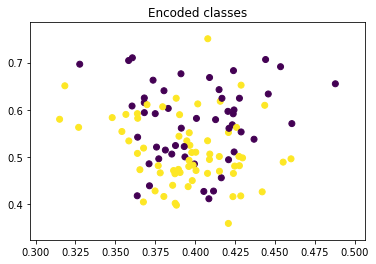

In [4]:
### PLOT EMBEDDING ###
# only possible of middle layer has dim=2
encoding = ae.encode(x_test)
plt.scatter(encoding[:,0], encoding[:,1], c=y_test)
plt.title('Encoded classes')
plt.show()

#### 2.1. Create and train a classifier using a keras-Sequential model and evaluate its classification performance on the breast cancer dataset. Use 80% of the data for training and 20% for testing

In [5]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

### LOAD DATA ###
dataset = load_breast_cancer()
x = pd.DataFrame(StandardScaler().fit_transform(dataset.data), columns=dataset.feature_names)
y = pd.DataFrame(dataset.target, columns=['malignant'])
y = np.eye(2)[y.values.reshape(-1)]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### CREATE MODEL ###
classifier = Sequential()
classifier.add(Dense(20, activation='sigmoid', input_shape=(30,)))
classifier.add(Dense(2, activation='softmax'))

classifier.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1))

classifier.fit(x_train, y_train, epochs=100, verbose=3)


### EVALUATE ###
y_pred = np.argmax(classifier.predict(x_test), axis=1)
precision_recall_fscore_support(np.argmax(y_test, axis=1), y_pred, average='macro')

W0913 09:43:22.321665 4517074368 deprecation.py:323] From /Users/torbenschnuchel/anaconda3/envs/passaudatascience/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

(0.9805128205128205, 0.9805128205128205, 0.9805128205128206, None)